In [1]:
import sys
sys.path.insert(0, '../src')

from megs.model.mPCA import mPCA
from megs.data import image, DataLoader, Galaxy

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

import numpy as np
import pickle

import seaborn as sns
sns.set_context("paper", font_scale=1.5)

# Load mm object from the file
#filename = "morphmodel.pkl"
#filename = "2dmorphmodel400.pkl"
#with open(filename, "rb") as file:
#    mm = pickle.load(file)

In [2]:
data = DataLoader("/export/home/ucakir/MEGS/MEGS/src/megs/data/galaxy_data.hdf5", m_min = 8)


File: /export/home/ucakir/MEGS/MEGS/src/megs/data/galaxy_data.hdf5
Group: Galaxies
    Group: Attributes
        Dataset: halo_id (float32) ((12484,))
        Dataset: mass (float32) ((12484,))
    Group: Particles
        Group: stars
            Group: Images
                Group: dim2
                    Dataset: GFM_Metallicity (float32) ((12484, 64, 64))
                    Dataset: GFM_StellarFormationTime (float32) ((12484, 64, 64))
                    Dataset: Masses (float32) ((12484, 64, 64))
                Group: dim3
                    Dataset: GFM_Metallicity (float32) ((12484, 64, 64, 64))
                    Dataset: GFM_StellarFormationTime (float32) ((12484, 64, 64, 64))
                    Dataset: Masses (float32) ((12484, 64, 64, 64))


In [3]:
norm = image.norm # Normalization function
lower = 0.25
upper = 1.0
norm_function_args = {"Masses": {"takelog": True, "plusone": True,"lower": lower, "upper": upper},
                     "GFM_Metallicity": {"takelog": True, "plusone": True, "lower": 0.25, "upper": upper},
                     "GFM_StellarFormationTime": {"takelog": True, "plusone": True, "lower": 0.25, "upper": upper},
                    
}


In [4]:
mm = mPCA(data, norm_function = norm, norm_function_kwargs=norm_function_args, dim = 2)

Creating datamatrix with the following fields:
Particle type:  stars
Fields:  ['GFM_Metallicity', 'GFM_StellarFormationTime', 'Masses']
Dimension:  dim2
Default arguments are used for the fields that are not specified in the norm_function_kwargs


Created datamatrix with shape:  (12484, 12288)


In [49]:
mm.fit(n_components = 60, show_results=False)

In [50]:
scores = mm.get_scores()
eigengalaxies = mm.get_eigengalaxies()
images = mm.get_images()
means = mm.get_means()

In [51]:
print(eigengalaxies.shape)
print(mm._IMG_ORDER)

(60, 3, 64, 64)
['GFM_Metallicity', 'GFM_StellarFormationTime', 'Masses']


In [52]:
metal_eigen = eigengalaxies[:,0]
age_eigen = eigengalaxies[:,1]
mass_eigen = eigengalaxies[:,2]

means_metal = means[:,0]
means_age = means[:,1]
means_mass = means[:,2]

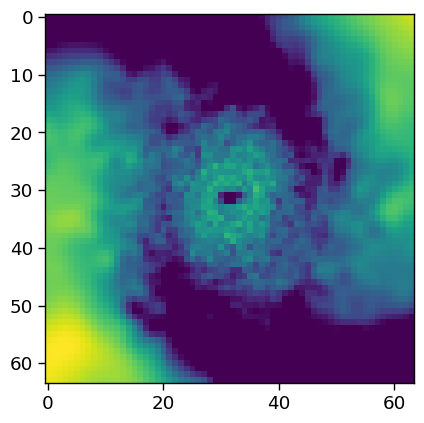

In [53]:
plt.imshow(images[10][1])

(60,)


[None, None, None, None, None, None]

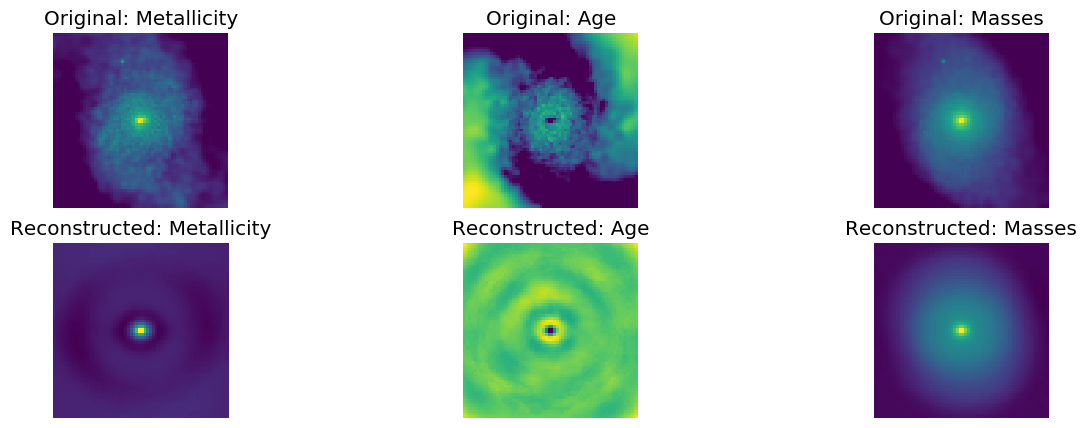

In [89]:
 # zeros = np.zeros((3,64*64))
galaxy_id = 10
map_index = 2
galaxy_img = images[galaxy_id][map_index].flatten()
# zeros[map_index] = galaxy_img
galaxy_minus_mean = galaxy_img - means[map_index].flatten()

# galaxy_vec = zeros-means.reshape(len(means),-1)
# galaxy_vec = galaxy_vec.flatten()

# projection = np.dot(galaxy_vec,eigengalaxies.reshape(len(eigengalaxies),-1).T)
# projection = np.dot(galaxy_minus_mean, eigengalaxies[:,map_index].reshape(len(eigengalaxies),-1).T)

# Ensure that the eigengalaxies have the correct shape
eigengalaxies = eigengalaxies.reshape(len(eigengalaxies),-1)

# You need to provide data for all maps to project onto the eigengalaxies
# If some maps are missing, you can fill them with zeros (or any other method depending on your use case)
zeros = np.zeros((3, 64*64))
zeros[map_index] = galaxy_img  # Fill the known map
galaxy_vec = zeros.flatten()  # Flatten the data

# Subtract the mean
galaxy_minus_mean = galaxy_vec - means.flatten()

# Now you can project onto the eigengalaxies
projection = np.dot(galaxy_minus_mean, eigengalaxies.T)



print(projection.shape)


# Reconstrunction
recon = means.flatten()+ np.dot(projection, eigengalaxies.reshape(len(eigengalaxies),-1))
recon = recon.reshape(3,64,64)

# recon = mm.reconstruct(projection)
fig,ax = plt.subplots(2,3, figsize=(15,5))

ax[0,0].imshow(images[galaxy_id][0])
ax[0,0].set_title("Original: Metallicity")

ax[0,1].imshow(images[galaxy_id][1])
ax[0,1].set_title("Original: Age")
ax[0,2].imshow(images[galaxy_id][2])
ax[0,2].set_title("Original: Masses")



ax[1,0].imshow(recon[0])
ax[1,0].set_title("Reconstructed: Metallicity")

ax[1,1].imshow(recon[1])
ax[1,1].set_title("Reconstructed: Age")

ax[1,2].imshow(recon[2])
ax[1,2].set_title("Reconstructed: Masses")


[axi.set_axis_off() for axi in ax.ravel()]

In [93]:
from megs.data.galaxy import Galaxy
basepath = "/export/data/ucakir/TNG100/TNG100-1/output/"
from astropy.visualization import make_lupton_rgb

In [92]:
g = Galaxy("IllustrisTNG", halo_id=20, particle_type="stars", base_path=basepath, snapshot=99)

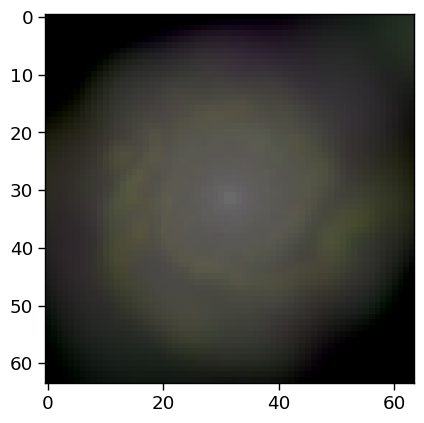

In [100]:
mass = g.get_image("Masses", normed = True)
metallicity = g.get_image("GFM_Metallicity", normed = True, mass_weighted=False)
age = g.get_image("GFM_StellarFormationTime", normed = True, mass_weighted=False)

# Normalize the parameters to the range [0,1] 
mass = (mass - np.min(mass)) / (np.max(mass) - np.min(mass))
metallicity = (metallicity - np.min(metallicity)) / (np.max(metallicity) - np.min(metallicity))
age = (age - np.min(age)) / (np.max(age) - np.min(age))

# Generate the RGB image
rgb = make_lupton_rgb(mass, metallicity, age, Q=10, stretch=0.5)

# Display the image
plt.imshow(rgb)
plt.show()

In [95]:
rgb.shape

(1, 44028, 3)

In [62]:


def predict_map(galaxy_id,map_index):
    # zeros = np.zeros((3,64*64))
    galaxy_img = images[galaxy_id][map_index].flatten()
    # zeros[map_index] = galaxy_img
    galaxy_minus_mean = galaxy_img - means[map_index].flatten()

    # galaxy_vec = zeros-means.reshape(len(means),-1)
    # galaxy_vec = galaxy_vec.flatten()

    # projection = np.dot(galaxy_vec,eigengalaxies.reshape(len(eigengalaxies),-1).T)
    projection = np.dot(galaxy_minus_mean, eigengalaxies[:,map_index].reshape(len(eigengalaxies),-1).T)
    print(projection.shape)


    # Reconstrunction
    recon = mm.reconstruct(projection)

    fig,ax = plt.subplots(2,3, figsize=(15,5))

    ax[0,0].imshow(images[galaxy_id][0])
    ax[0,0].set_title("Original: Metallicity")

    ax[0,1].imshow(images[galaxy_id][1])
    ax[0,1].set_title("Original: Age")
    ax[0,2].imshow(images[galaxy_id][2])
    ax[0,2].set_title("Original: Masses")



    ax[1,0].imshow(recon[0])
    ax[1,0].set_title("Reconstructed: Metallicity")

    ax[1,1].imshow(recon[1])
    ax[1,1].set_title("Reconstructed: Age")

    ax[1,2].imshow(recon[2])
    ax[1,2].set_title("Reconstructed: Masses")


    [axi.set_axis_off() for axi in ax.ravel()]

(60,)


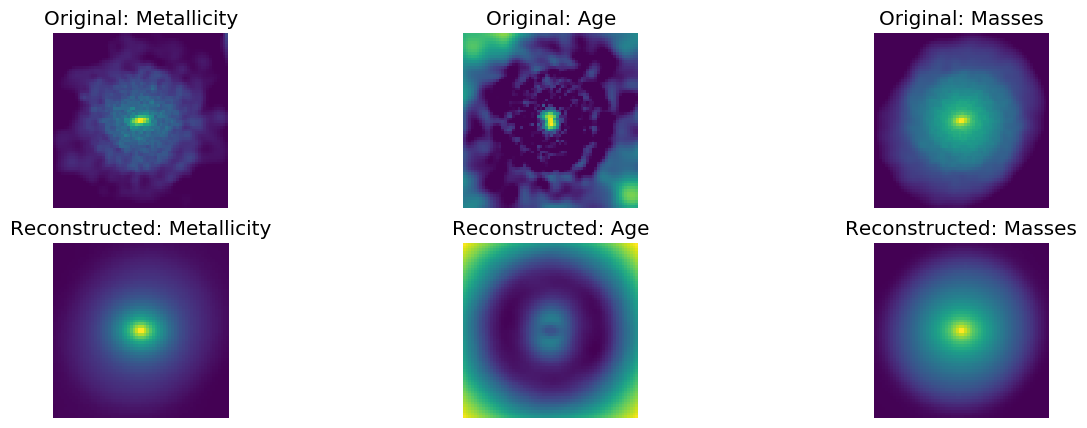

In [77]:
predict_map(21,2)

In [45]:
from ppca import PPCA
n_comp = 60
ppca = PPCA()

ppca.fit(images.reshape(len(images),-1), d = n_comp)  



/export/home/ucakir/.local/lib/python3.8/site-packages/ppca/_ppca.py:82: RuntimeWarning: divide by zero encountered in log
  det = np.log(np.linalg.det(Sx))


In [161]:
def show_eigengalaxies(self,field="GFM_Metallicity", cmap="RdBu_r", font_size = 25, save_path=None):
    index = self._IMG_ORDER.index(field)
    eigen = self.get_eigengalaxies()[:, index]
    mean = self.get_means()[index]
    # Insert mean to beginning of eigen
    eigen = np.insert(eigen, 0, mean, axis=0)
    n_eigen = len(eigen) 
    
    # Calculate the optimal grid layout
    n_rows = int(np.ceil(np.sqrt(n_eigen)))
    n_cols = int(np.ceil(n_eigen / n_rows))
    
    figsize = (n_cols * 4, n_rows * 4)
    
    # Create the subplots using gridspec
    fig = plt.figure(figsize=figsize)
    width_ratios = [1] * n_cols + [0.5]
    gs = GridSpec(n_rows, n_cols+1, figure=fig,width_ratios=width_ratios)
    
    # Plot the eigengalaxies
    for i in range(n_eigen):
        ax = fig.add_subplot(gs[i])
        if i == 0:
            ax.set_title("Mean", fontsize=font_size)
        else:
            ax.set_title(i, fontsize=font_size)
        im = ax.imshow(eigen[i], cmap=cmap)
        ax.axis('off')
    
    # Add a colorbar using gridspec
    cbar_ax = fig.add_subplot(gs[:, -1])
    cbar = plt.colorbar(im, cax=cbar_ax)
    cbar.set_label(field, fontsize=font_size)
    cbar.ax.tick_params(labelsize=font_size)
    
    # Adjust spacing between subplots
    fig.tight_layout()
    if save_path is not None:
        plt.savefig(save_path,dpi = 300)
    # Display the plot
    plt.show()  

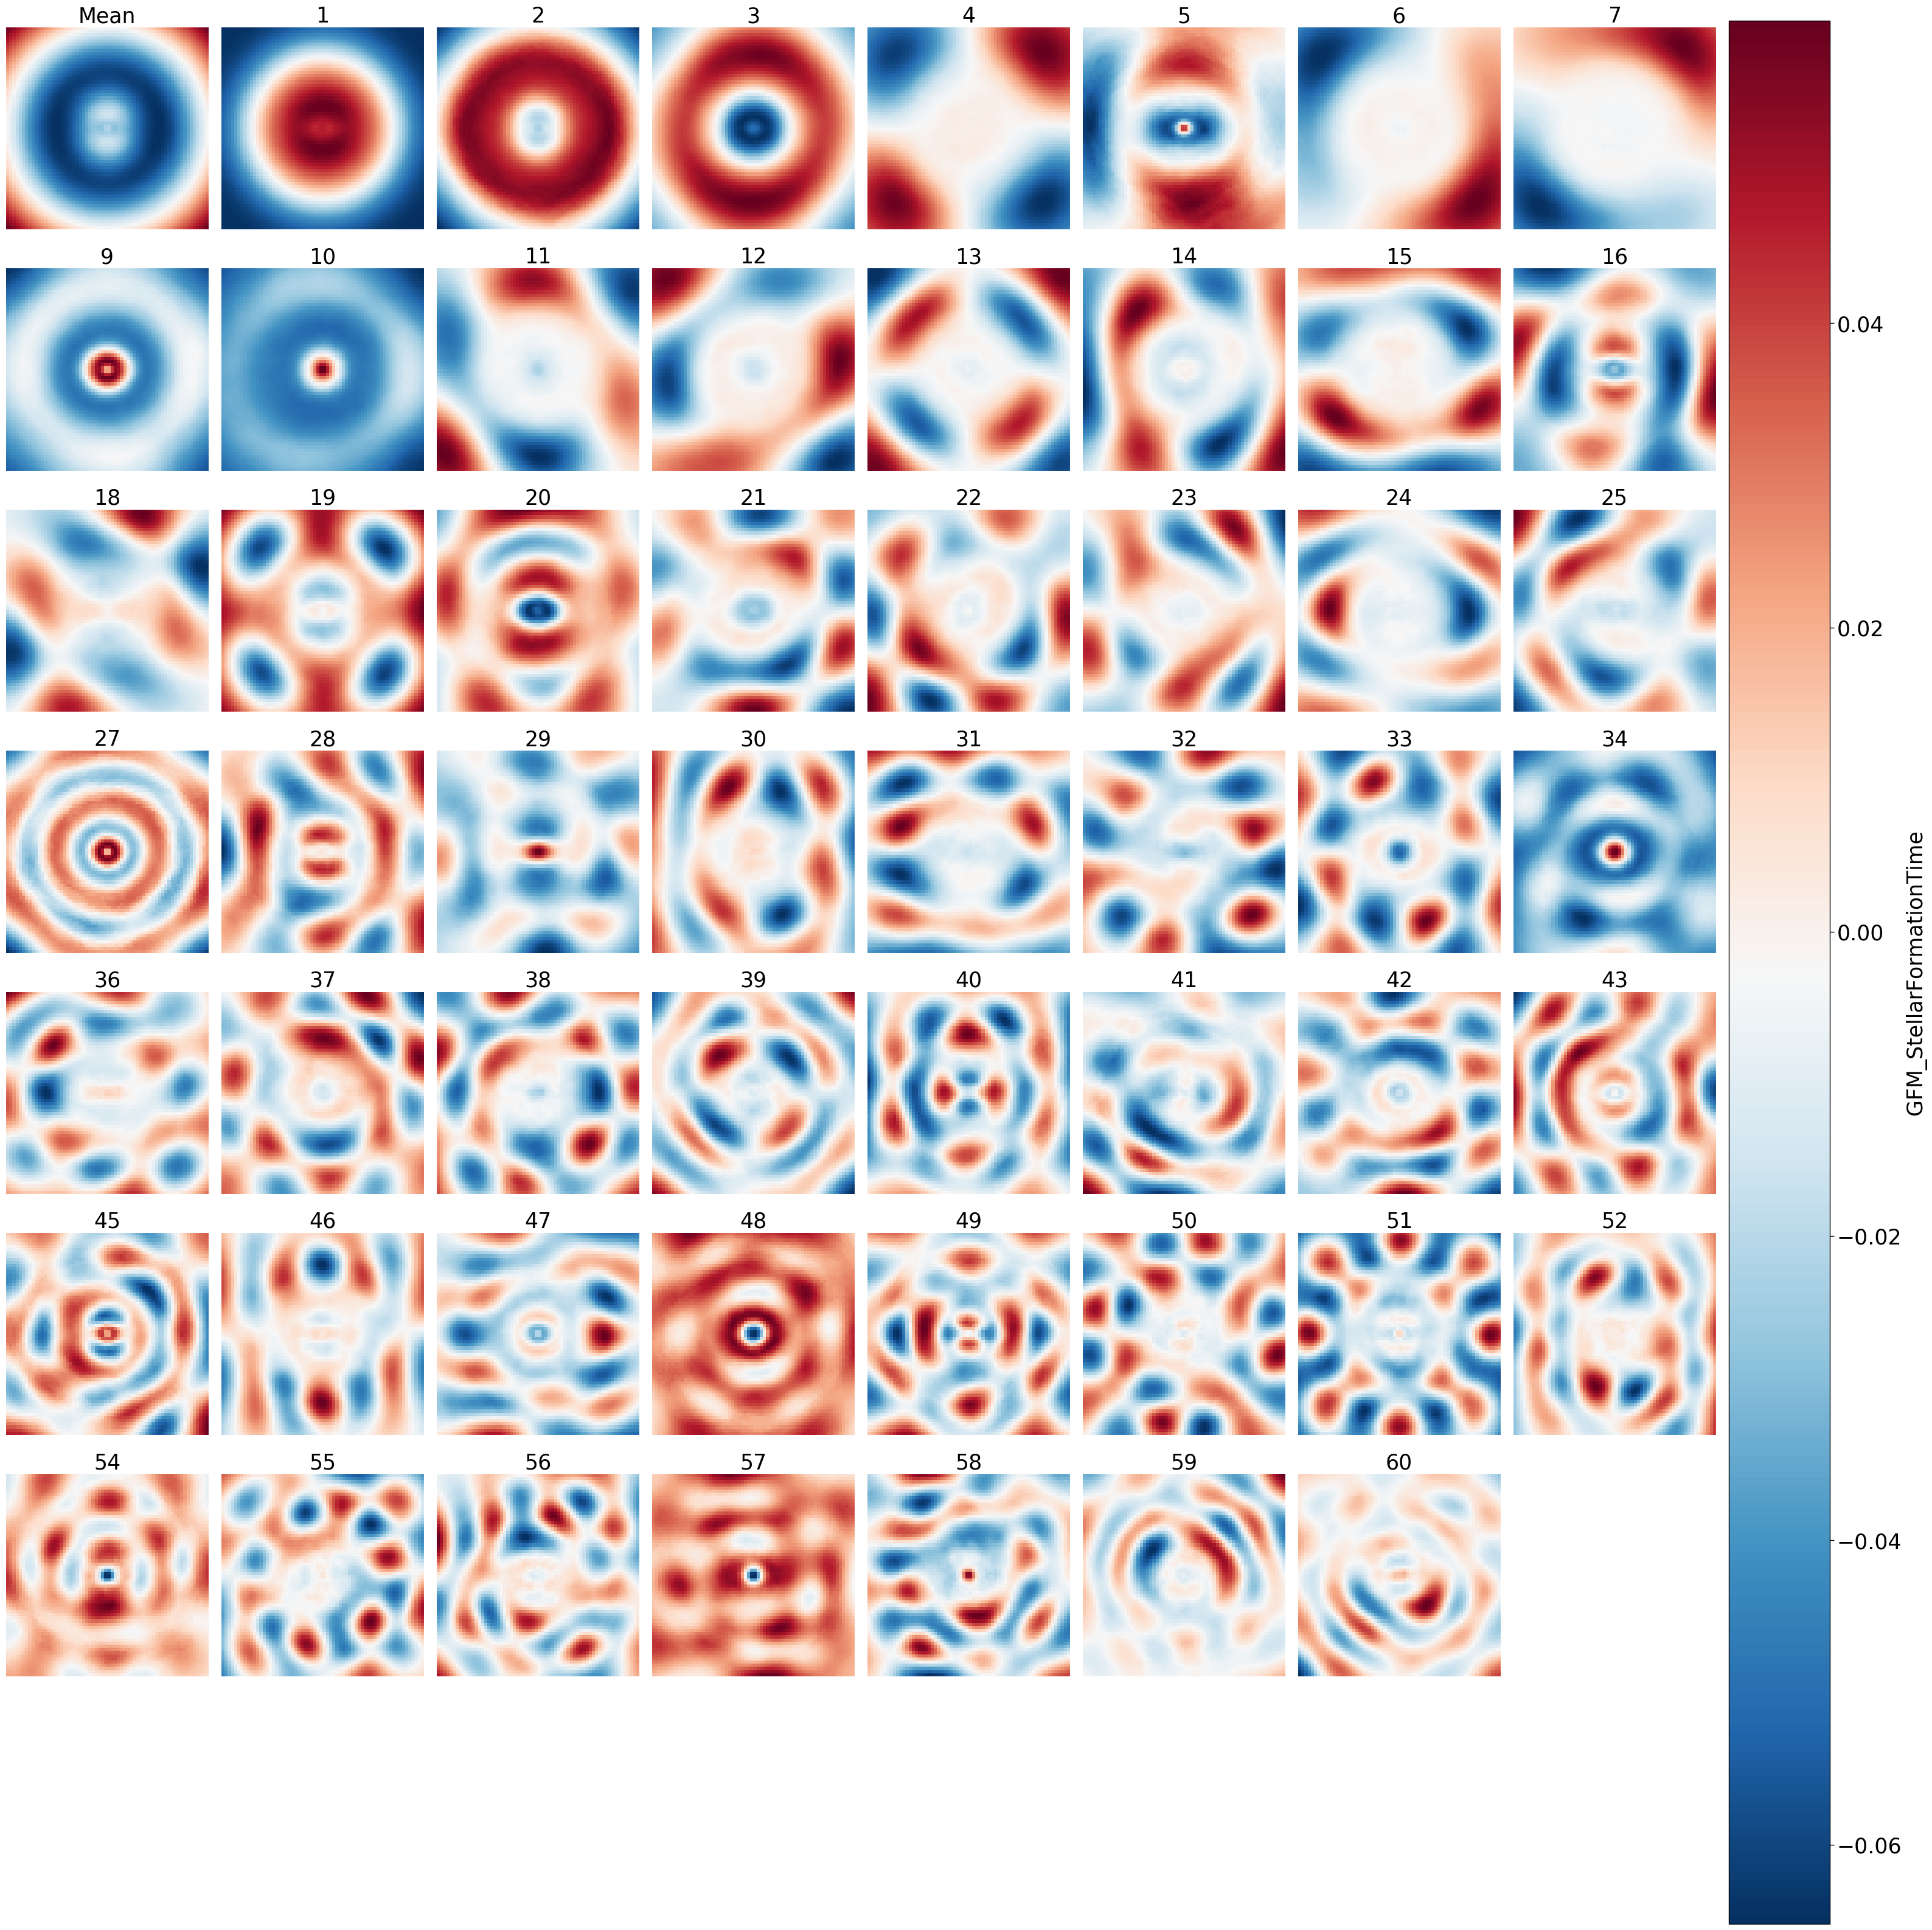

In [167]:
show_eigengalaxies(mm, field="GFM_StellarFormationTime", font_size = 25, save_path="plots/eigengalaxies_age.png")

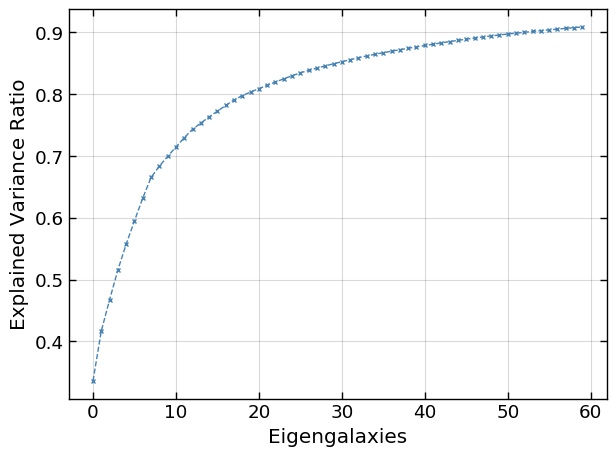

In [172]:
# Explained variance ratio

#plt.figure(figsize=(5,5))
plt.plot(np.arange(mm.pca.n_components_), np.cumsum(mm.pca.explained_variance_ratio_), marker="x", color="steelblue", linestyle="dashed", linewidth=1, markersize=3,)
plt.xlabel("Eigengalaxies")
plt.ylabel("Explained Variance Ratio")
plt.grid()
plt.tick_params(bottom=True, top=True, left=True, right=True, direction='in', which='major', grid_color='black', grid_alpha=0.15)
plt.tight_layout()
plt.savefig("plots/explained_variance.png", dpi=300)

In [6]:
# Try to predict the two other maps from the first one
data = mm.get_images()
scores = mm.get_scores()
eigengalaxies = mm.get_eigengalaxies()
metaleigen= eigengalaxies[:,0,:].reshape(len(eigengalaxies), -1)
means = mm.get_means()
metal_means = means[0].reshape( -1)
metal_img = data[:,0,:].reshape(len(data), -1)
print(data.shape, scores.shape)

X = data[:,0,:].reshape(len(data), -1)

# Project metal maps to the eigengalaxies

scores_metal = np.dot(metal_img - metal_means, metaleigen.T)
X = scores_metal
Y = scores

from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

(12484, 3, 64, 64) (12484, 60)


In [44]:
from sklearn.cluster import KMeans

#Apply kmeans to the scores

kmeans = KMeans(n_clusters=10, random_state=0).fit(Y_train)



In [48]:
from sklearn.cluster import AffinityPropagation
clust=AffinityPropagation(damping=0.9,convergence_iter=100,max_iter=1000)
clust=clust.fit(scores)



In [52]:
print("labels", len(np.unique(clust.labels_)))

labels 383


In [55]:
clust.cluster_centers_.shape

(383, 60)

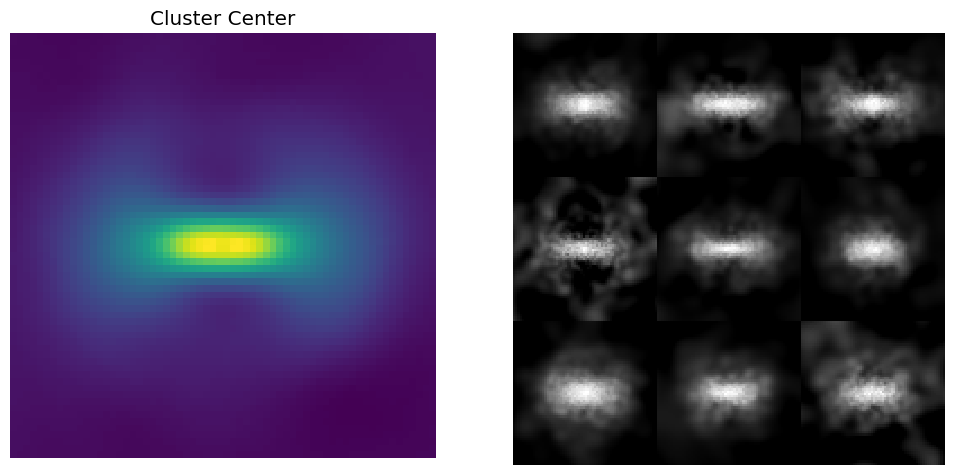

In [111]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

# Create a 2x2 grid layout
fig = plt.figure()
grid = ImageGrid(fig, 111, nrows_ncols=(2, 2), axes_pad=0)

# Plot the cluster center on the left
centerindex = 11
grid[0].imshow(clust_rec[centerindex][0])
grid[0].set_title("Cluster Center")
grid[0].axis('off')

[grid[i].axis('off') for i in range(1, 4)]

# Get the sample galaxies from the cluster
galaxy_in_cluster = data[clust.labels_ == centerindex][:, 0]
num_samples = min(9, len(galaxy_in_cluster))

# Adjust the spacing and positioning of subplots
plt.subplots_adjust(left=-2, right=1, bottom=0.05, top=0.95, wspace=0.1, hspace=2)

# Plot the grid of sample galaxies on the right
subgrid = ImageGrid(fig, 122, nrows_ncols=(3, 3), axes_pad=0)
for i in range(num_samples):
    subgrid[i].imshow(galaxy_in_cluster[i], cmap="gray")
    subgrid[i].axis('off')

# Show the plot
plt.show()



In [147]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np


def plot_cluster(center_index ,cluster_centers,cluster_labels, data, map_index, save_path = None):
    clust_rec = np.apply_along_axis(mm.reconstruct, 1, cluster_centers)
    fig = plt.figure()
    grid = ImageGrid(fig, 121, nrows_ncols=(1, 2), axes_pad=0)

    grid[0].imshow(clust_rec[center_index][map_index], cmap ="gray")
    grid[0].set_title("Cluster Center")
    grid[0].axis('off')


    [grid[i].axis('off') for i in range(1, 2)]
    # Get the sample galaxies from the cluster
    galaxy_in_cluster = data[cluster_labels == center_index][:, map_index]
    num_samples = min(9, len(galaxy_in_cluster))

    # Plot the 3x3 grid of sample galaxies on the right
    subgrid = ImageGrid(fig, 122, nrows_ncols=(3, 3), axes_pad=0)
    for i in range(num_samples):
        random_index = np.random.randint(0, len(galaxy_in_cluster))
        subgrid[i].imshow(galaxy_in_cluster[random_index], cmap="gray")
        subgrid[i].axis('off')

    subgrid[1].set_title("Sample Galaxies")
    #[subgrid[i].axis('off') for i in range(num_samples, 9)]
    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    if save_path is not None:
        plt.savefig(save_path, dpi = 300)
    plt.show()
    plt.close()


In [153]:
def plot_cluster(center_index, cluster_centers, cluster_labels, data, save_path=None):
    clust_rec = np.apply_along_axis(mm.reconstruct, 1, cluster_centers)
    fig = plt.figure(figsize=(12, 8))

    # Plot GFM_metallicity cluster center and sample galaxies
    ax1 = fig.add_subplot(231)
    ax1.imshow(clust_rec[center_index][0], cmap="gray")
    ax1.set_title("GFM_metallicity Center")
    ax1.axis('off')
    galaxy_in_cluster1 = data[cluster_labels == center_index][:, 0]
    for i in range(min(9, len(galaxy_in_cluster1))):
        ax1 = fig.add_subplot(234 + i)
        ax1.imshow(galaxy_in_cluster1[i], cmap="gray")
        ax1.axis('off')

    # Plot Stellar Age cluster center and sample galaxies
    ax2 = fig.add_subplot(232)
    ax2.imshow(clust_rec[center_index][1], cmap="gray")
    ax2.set_title("Stellar Age Center")
    ax2.axis('off')
    galaxy_in_cluster2 = data[cluster_labels == center_index][:, 1]
    for i in range(min(9, len(galaxy_in_cluster2))):
        ax2 = fig.add_subplot(235 + i)
        ax2.imshow(galaxy_in_cluster2[i], cmap="gray")
        ax2.axis('off')

    # Plot masses cluster center and sample galaxies
    ax3 = fig.add_subplot(233)
    ax3.imshow(clust_rec[center_index][2], cmap="gray")
    ax3.set_title("Masses Center")
    ax3.axis('off')
    galaxy_in_cluster3 = data[cluster_labels == center_index][:, 2]
    for i in range(min(9, len(galaxy_in_cluster3))):
        ax3 = fig.add_subplot(236 + i)
        ax3.imshow(galaxy_in_cluster3[i], cmap="gray")
        ax3.axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save or display the plot
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
        plt.close()
    else:
        plt.show()
        plt.close()



ValueError: num must be 1 <= num <= 6, not 7

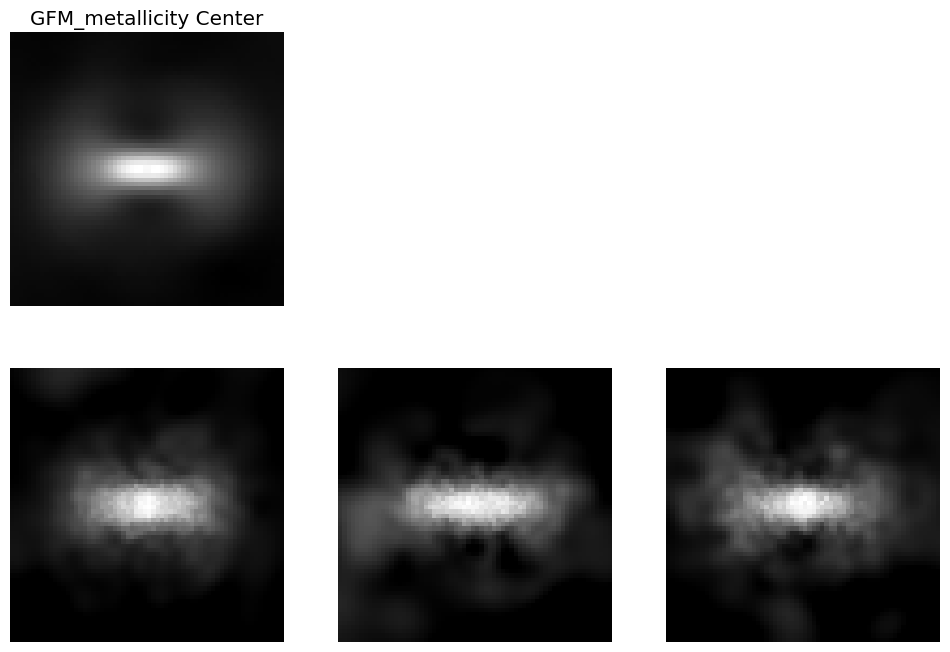

In [154]:
plot_cluster(11,clust.cluster_centers_,clust.labels_,data, save_path = "plots/cluster11_metal.png")

IndexError: index 4 is out of bounds for axis 1 with size 4

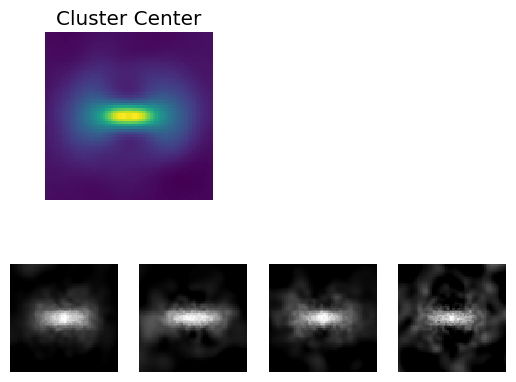

In [91]:
clust_rec = np.apply_along_axis(mm.reconstruct, 1, clust.cluster_centers_)

import matplotlib.gridspec as gridspec
# Create a 2x3 grid layout

grid = gridspec.GridSpec(2, 4)

# Plot the cluster center
centerindex = 11
plt.subplot(grid[0, 0:2])  # Span the first two cells in the first row
plt.imshow(clust_rec[centerindex][0])
plt.title("Cluster Center")
plt.axis('off')

# Get the sample galaxies from the cluster
galaxy_in_cluster = data[clust.labels_ == centerindex][:, 0]
num_samples = min(9, len(galaxy_in_cluster))

# Plot the grid of sample galaxies
for i in range(num_samples):
    plt.subplot(grid[1, i])  # Use the second row of the grid
    plt.imshow(galaxy_in_cluster[i], cmap="gray")
    plt.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [70]:
galaxy_in_cluster.shape

(24, 3, 64, 64)

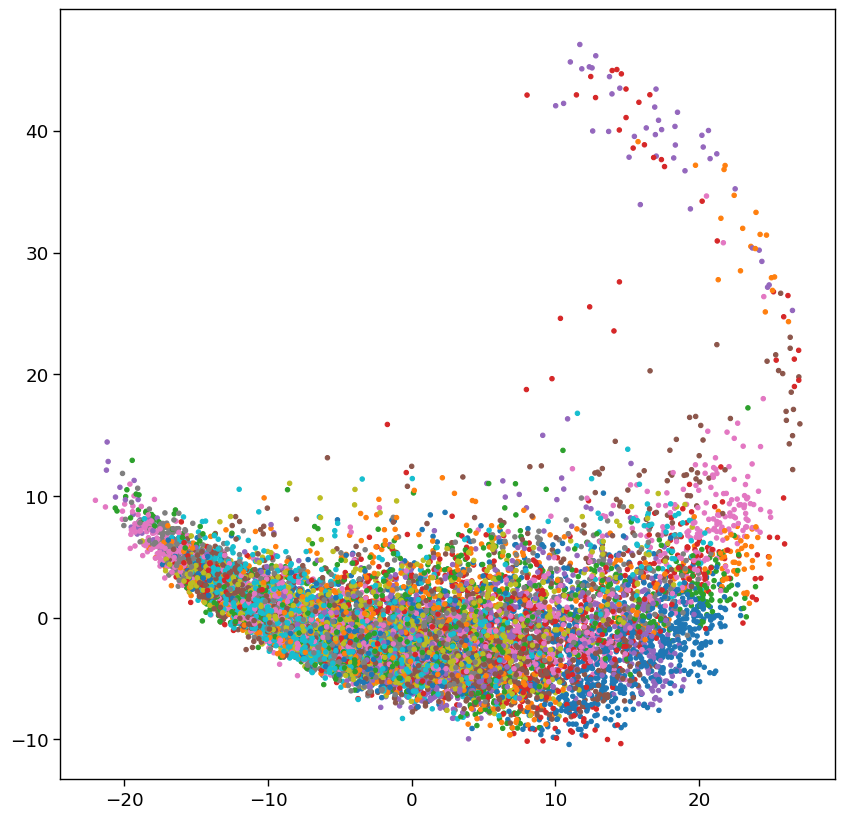

7

In [24]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Assuming X and Y are PCA components of metallicity maps and full maps respectively.

# Convert to PyTorch tensors
X_tensor = torch.tensor(X).float()
Y_tensor = torch.tensor(Y).float()

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)

# Create PyTorch datasets and data loaders for training and testing sets
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network architecture
model = nn.Sequential(
    nn.Linear(60, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 60)
)

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(100):  # change the number of epochs to suit your data
    for i, (inputs, targets) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        print('Test Loss: {:.4f}'.format(loss.item()))


Epoch [1/100], Loss: 3.6177
Epoch [2/100], Loss: 4.0288
Epoch [3/100], Loss: 2.4708
Epoch [4/100], Loss: 2.6736
Epoch [5/100], Loss: 2.2754
Epoch [6/100], Loss: 2.3519
Epoch [7/100], Loss: 2.2251
Epoch [8/100], Loss: 2.0948
Epoch [9/100], Loss: 2.0781
Epoch [10/100], Loss: 3.7378
Epoch [11/100], Loss: 3.2989
Epoch [12/100], Loss: 2.5901
Epoch [13/100], Loss: 3.5708
Epoch [14/100], Loss: 2.2927
Epoch [15/100], Loss: 3.6468
Epoch [16/100], Loss: 2.3030
Epoch [17/100], Loss: 2.4961
Epoch [18/100], Loss: 2.5190
Epoch [19/100], Loss: 1.7916
Epoch [20/100], Loss: 2.7510
Epoch [21/100], Loss: 2.5955
Epoch [22/100], Loss: 3.4539
Epoch [23/100], Loss: 2.5384
Epoch [24/100], Loss: 2.7902
Epoch [25/100], Loss: 1.2585
Epoch [26/100], Loss: 3.7454
Epoch [27/100], Loss: 2.6807
Epoch [28/100], Loss: 1.2939
Epoch [29/100], Loss: 2.8656
Epoch [30/100], Loss: 1.5005
Epoch [31/100], Loss: 2.3566
Epoch [32/100], Loss: 3.5968
Epoch [33/100], Loss: 5.4192
Epoch [34/100], Loss: 1.6841
Epoch [35/100], Loss: 2

In [27]:
model.eval()
with torch.no_grad():
    outputs = model(X_test)


In [30]:
pred = outputs.numpy()
targets = Y_test.numpy()

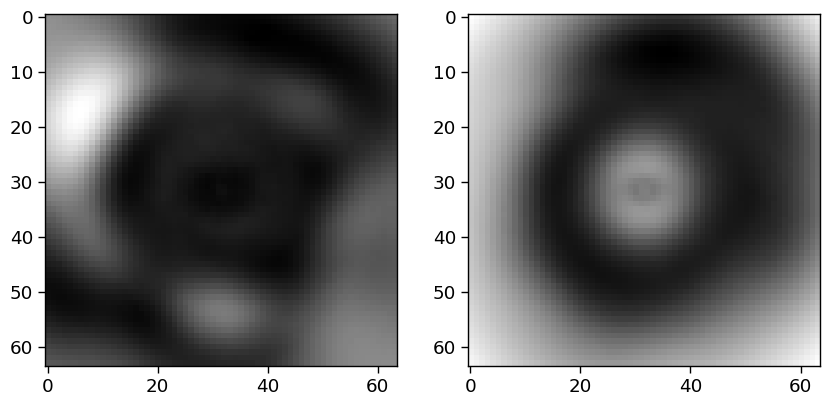

In [42]:
galind = 8

imgtest = mm.reconstruct(targets[galind])
imgpred = mm.reconstruct(pred[galind])

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(imgtest[1], cmap="gray")

ax[1].imshow(imgpred[1], cmap="gray")

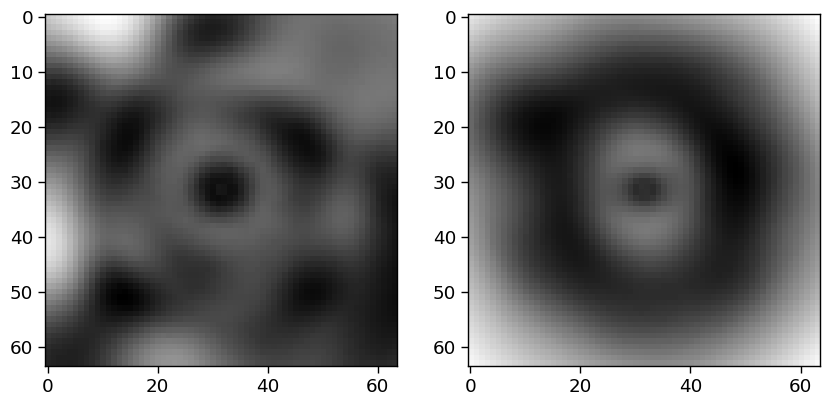

In [22]:
galind = 13

imgtest = mm.reconstruct(Y_test[galind])
imgpred = mm.reconstruct(Y_pred[galind])

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(imgtest[1], cmap="gray")

ax[1].imshow(imgpred[1], cmap="gray")


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# assuming X is your flattened Metallicity maps and Y is your PCA scores
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize the model
model2 = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
model2.fit(X_train, y_train)

# Predict PCA scores
y_pred = model2.predict(X_test)

# Now you can use y_pred (the predicted PCA scores) to reconstruct the images for other maps


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# assuming X is your flattened Metallicity maps and Y is your PCA scores
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict PCA scores
y_pred = model.predict(X_test)

# Now you can use y_pred (the predicted PCA scores) to reconstruct the images for other maps


In [12]:
#save model
filename = "rf_model.pkl"
import pickle
with open(filename, "wb") as file:
    pickle.dump(model, file)

In [15]:
import matplotlib.pyplot as plt

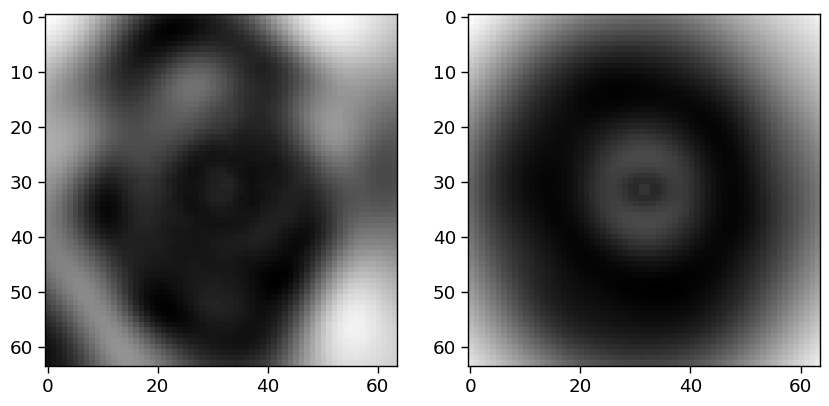

In [23]:
imgtest = mm.reconstruct(y_test[1])
imgpred = mm.reconstruct(y_pred[1])

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(imgtest[1], cmap="gray")

ax[1].imshow(imgpred[1], cmap="gray")


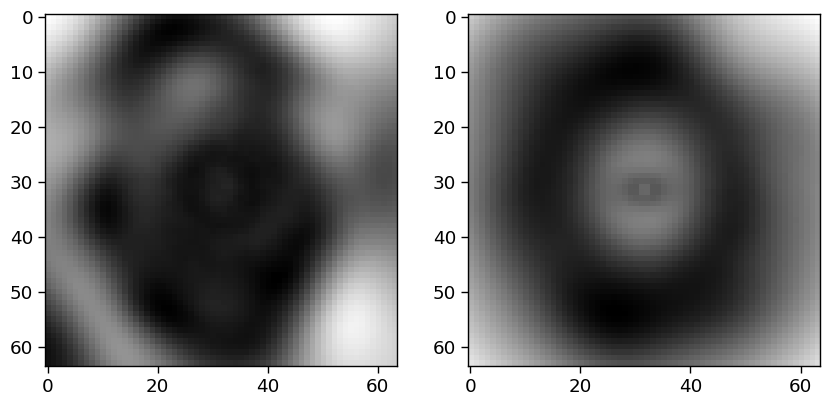

In [40]:
imgtest = mm.reconstruct(y_test[2])
imgpred = mm.reconstruct(y_pred[2])

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(imgtest[1], cmap="gray")
ax[1].imshow(imgpred[1], cmap="gray")

